# TrainData/TestData의 무음 구간(db이 낮은구간)을 삭제하고 특정 프레임(현재는 256)씩 잘라서 저장하는 형태. 오버랩이 되도록 저장한다.(Step size를 통해 결정)

In [1]:
import os
import numpy as np
from tqdm import tqdm_notebook
from utils import *
import librosa
import random
import multiprocessing as mp
import torch.utils.data
import pandas as pd
from sklearn.model_selection import train_test_split

seed_everything(42)

def process(t): ## args : drt, file,window,step
    drt,file,window,step,n_frame,top_db = t
    X,y = [],[]

    x,sr = librosa.load(drt+file,sr=16000,mono=False)
    itvs = librosa.effects.split(x[0],frame_length = n_frame+1, hop_length = step,top_db = top_db)
    
    for st_idx,end_idx in itvs:
        speech,egg = x[0][st_idx:end_idx],x[1][st_idx:end_idx]
        i=0
        while(i*step+window < len(speech)):
            tmp_speech = speech[i*step:i*step+window]
            tmp_egg = egg[i*step:i*step+window]
            if check_data(tmp_speech,tmp_egg,0.2,n_frame):
                X.append(tmp_speech)
                y.append(tmp_egg)
            i+=1
    return (X,y)
   
def load_datas(n_frame,window,step,top_db,is_test=False):
    X,y = [],[]
    pool = mp.Pool(mp.cpu_count())
    
    print("load Train Data")
    args = []
    
    for drt in ['./datasets/TrainData/Alexis/','./datasets/TrainData/vietnam/','./datasets/TrainData/Childer/',
                './datasets/TrainData/CMU/','./datasets/TrainData/saarbrucken/']:
        for file in os.listdir(drt):
            if 'wav' in file:
                args.append((drt,file,window,step,n_frame,top_db))

    if is_test:
        args = args[:50]
    
    tmp = list(tqdm_notebook(pool.imap(process,args),total = len(args)))
    for _x,_y in tmp:
        if len(_x) >0 and len(_y) > 0:
            X +=_x
            y +=_y
    pool.close()
    pool.join()
    
    release_list(tmp)
    X = np.array(X)
    y = np.array(y)
    train_X,val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=42)
    return train_X, train_y, val_X, val_y

In [2]:
train_X, train_y, val_X, val_y = load_datas(n_frame = 256,
                                            window = int(256*(1.25)),
                                            step = int(256//4),
                                            top_db = 20,
                                            is_test = False)

load Train Data


In [5]:
def save_parallel_train(i):
    np.save('./datasets/TrainData/trainX/%d.npy'%i,train_X[i])
    np.save('./datasets/TrainData/trainy/%d.npy'%i,train_y[i])
    return 0

def save_parallel_val(i):
    np.save('./datasets/TrainData/valX/%d.npy'%i,val_X[i])
    np.save('./datasets/TrainData/valy/%d.npy'%i,val_y[i])
    return 0

In [6]:
%%time

os.makedirs('./datasets/TrainData/trainX/',exist_ok=True)
os.makedirs('./datasets/TrainData/valX/',exist_ok=True)
os.makedirs('./datasets/TrainData/trainy/',exist_ok=True)
os.makedirs('./datasets/TrainData/valy/',exist_ok=True)

pool = mp.Pool(mp.cpu_count())
pool.map(save_parallel_train,range(train_X.shape[0]))
pool.close()
pool.join()

CPU times: user 2.49 s, sys: 18.9 s, total: 21.4 s
Wall time: 26min 16s


In [7]:
%%time

pool = mp.Pool(mp.cpu_count())
pool.map(save_parallel_val,range(val_X.shape))
pool.close()
pool.join()

CPU times: user 713 ms, sys: 19.2 s, total: 19.9 s
Wall time: 7min 11s


In [2]:
import numpy as np
from utils import loudness_normalize

In [3]:
train = np.load('../eggdata/TrainData/train_processing.npy',mmap_mode='r')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

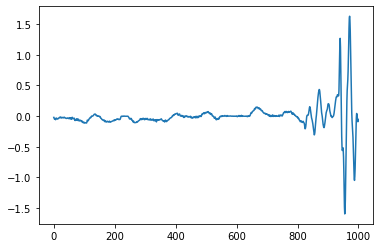

In [5]:
plt.plot(loudness_normalize(train[0,700:1700]))
# plt.plot(loudness_normalize(train[0,2000:4000]))
# plt.plot(loudness_normalize(train[0,4000:6000]))

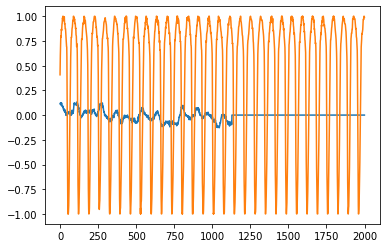

In [6]:
plt.plot(loudness_normalize(train[0,41000:43000])+1e-4)
plt.plot(train[1,31000:33000]+1e-4)
# plt.plot(loudness_normalize(train[0,4000:6000]))

In [7]:
def CosineDistanceLoss():
    def f(pred,true):
        return torch.mean(torch.acos(F.cosine_similarity(pred+1e-3,true+1e-3,dim=1,eps = 1e-4)),dim=0)
    return f

In [8]:
import torch
import torch.nn.functional as F

In [9]:
x = torch.Tensor(train[1:2,31005:33005,np.newaxis])
y = torch.Tensor(train[1:2,31000:33000,np.newaxis])

In [10]:
c = CosineDistanceLoss()

In [11]:
c(x,y)

tensor([0.5523])

In [15]:
torch.acos(torch.Tensor([1.5]))

tensor([nan])